In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 194kB 10.6MB/s 
     |████████████████████████████████| 1.2MB 15.1MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
Mounted at /content/gdrive


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  12,  99,  91, 142, 155, 246, 182, 155, 155, 155, 155, 131,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 138, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 252, 210, 122,  

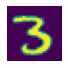

In [ ]:
from fastbook import *
path = untar_data(URLs.MNIST_SAMPLE)
# image를 불러옴
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

# image를 tensor로 바꿈
im3_t = tensor(im3)
im3_t

In [ ]:
# kernel 관련 함수 생성
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2,col-1:col+2] * kernel ).sum()

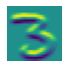

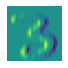

In [ ]:
# 참고
# list comprehensions
[[(i,j) for j in range (1,5)] for i in range(1,5)]

# 적용
rng = range(1,26)

# top
top_edge = tensor([[-1,-1,-1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3)

# left
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3)




### Result of applying a 3×3 kernel to a 4×4 image 
(courtesy of Vincent Dumoulin and Francesco Visin)

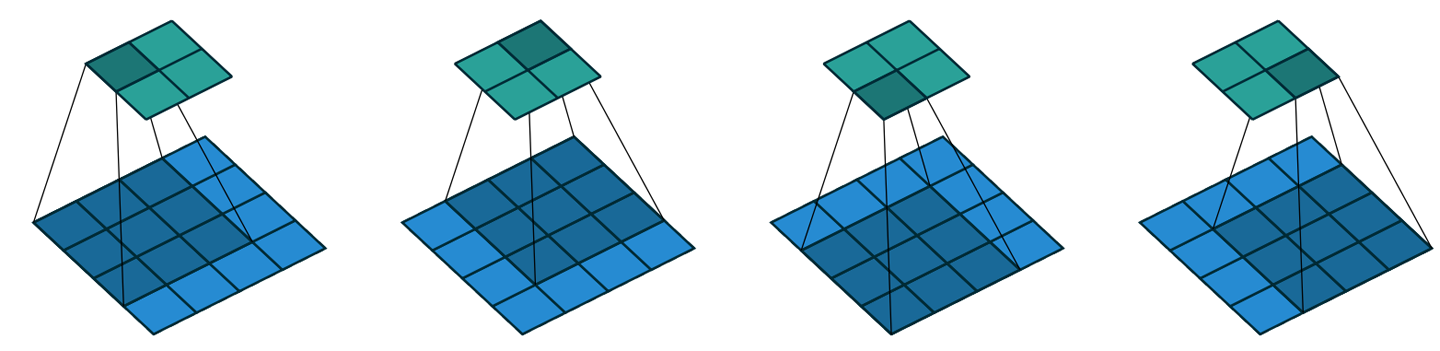

In [ ]:
# 실험
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]]).float()
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape


torch.Size([4, 3, 3])

In [ ]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape



torch.Size([64, 1, 28, 28])

In [ ]:
xb, yb = to_cpu(xb), to_cpu(yb)


In [ ]:
'''
input (Data)
input tensor of shape (minibatch, in_channels, iH, iW)

weight (Kernel)
filters of shape (out_channels, in_channels, kH, kW)
'''
edge_kernels.shape, edge_kernels.unsqueeze(1).shape
edge_kernels = edge_kernels.unsqueeze(1)

In [ ]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape


torch.Size([64, 4, 26, 26])

torch.Size([26, 26])


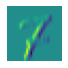

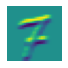

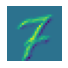

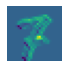

In [ ]:
print(batch_features[0,0].shape)

# 4개의 kernel을 사용해보았다.
for i in range(4):
 show_image(batch_features[0,i])

In [ ]:
batch_features[0,0,0].shape

torch.Size([26])

In [ ]:
## Creating CNN

# DNN
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

# CNN
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30,kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
# conv
def conv(ni, nf, ks = 3, act = True):
  res = nn.Conv2d(ni, nf, stride = 2, kernel_size= ks, padding = ks// 2)
  if act:
    res = nn.Sequential(res, nn.ReLU())
  return res


In [ ]:
simple_cnn = sequential(
    conv(1,4), # 14 x 14
    conv(4,8), # 7 x 7
    conv(8,16), # 4 x 4
    conv(16,32), # 2 x 2
    conv(32,2, act = False), # 1 x 1
    Flatten(),
)


In [ ]:
learn = Learner(dls, simple_cnn, loss_func = F.cross_entropy, metrics= accuracy)



In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [ ]:
learn.fit_one_cycle(5,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.252384,0.096449,0.966634,00:17
1,0.045336,0.059594,0.981354,00:17
2,0.033193,0.046616,0.985280,00:17
3,0.034229,0.043799,0.987242,00:16
4,0.031477,0.046133,0.986261,00:16


In [ ]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [ ]:
learn.model[1][0].weight

Parameter containing:
tensor([[[[ 0.0696,  0.0082, -0.0500],
          [ 0.1285,  0.1370,  0.0816],
          [-0.0662,  0.0102, -0.1066]],

         [[-0.0210,  0.0830,  0.1623],
          [-0.1184, -0.0376, -0.0459],
          [ 0.2752,  0.2125, -0.1240]],

         [[-0.0916,  0.0055, -0.1010],
          [-0.1469, -0.0891,  0.1861],
          [ 0.1355, -0.0171,  0.0444]],

         [[ 0.0875, -0.1796,  0.1094],
          [-0.0628, -0.1659,  0.2567],
          [ 0.0360,  0.1577,  0.1101]]],


        [[[ 0.1167,  0.0110, -0.0980],
          [ 0.1861, -0.0103,  0.1311],
          [ 0.2096,  0.0038,  0.0418]],

         [[ 0.2215,  0.0549,  0.2104],
          [ 0.0103,  0.1912,  0.0301],
          [ 0.0771,  0.0171,  0.1223]],

         [[ 0.2110,  0.0952,  0.0029],
          [ 0.3017,  0.2658,  0.0298],
          [ 0.0058, -0.0314,  0.1145]],

         [[ 0.1819,  0.0633,  0.0009],
          [-0.1453,  0.0690,  0.0427],
          [-0.0228, -0.1336,  0.0117]]],


        [[[-0.1164,  0

In [ ]:
# color images

im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

In [ ]:
# Improving Training Stabliity
path = untar_data(URLs.MNIST)
path.ls

<bound method Path.ls of Path('/root/.fastai/data/mnist_png')>

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

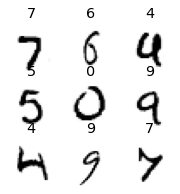

In [ ]:
dls.show_batch(max_n = 9, figsize = (3,3))

In [ ]:
def simple_cnn():
  return sequential(
      conv(1,8, ks = 5),
      conv(8,16),
      conv(16,32),
      conv(32,64),
      conv(64,10, act = False),
      Flatten(),
  )

In [ ]:
from fastai.callback.hook import *

In [ ]:
def fit(epochs = 1):
  learn = Learner(dls, simple_cnn(), loss_func = F.cross_entropy,
                  metrics = accuracy, cbs = ActivationStats(with_hist = True))
  learn.fit(epochs, 0.06)
  return learn
  

In [ ]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.307500,2.303685,0.103200,01:27


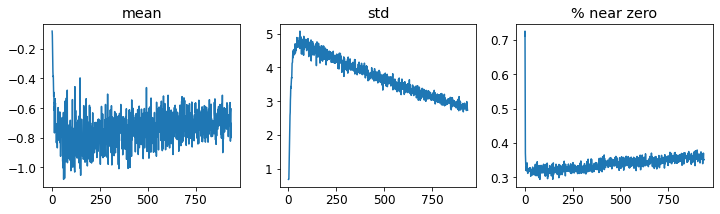

In [ ]:
'''

ActivationStats includes some handy utilities for plotting the activations during training.
plot_layer_stats(idx) plots the mean and standard deviation of the activations of layer number idx, 
along with the percentage of activations near zero. Here’s the first layer’s plot:

'''

learn.activation_stats.plot_layer_stats(0)

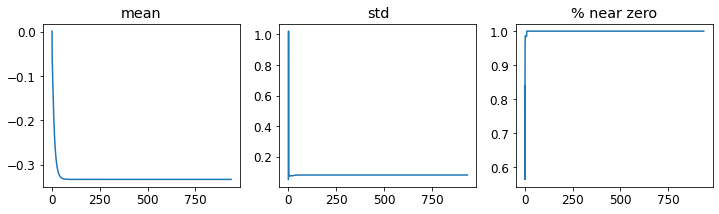

In [ ]:
learn.activation_stats.plot_layer_stats(-2)


In [ ]:
# batchsize 바꾸기
dls = get_dls(512)
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305743,2.301425,0.113500,01:12


In [ ]:
# learning rate를 중간마다 조정하기
# learing rate를 큰 값으로 시작했다가, 작은 값으로 점차 조정하기 
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr,)
    return learn
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.229356,0.088714,0.972200,01:13


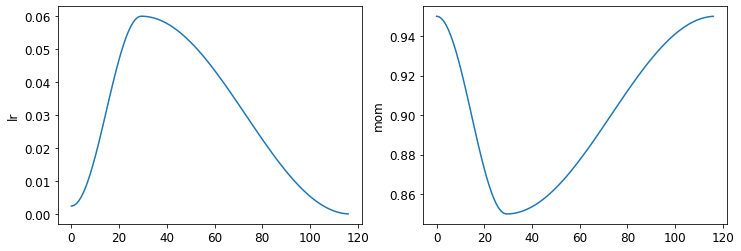

In [ ]:
# learing rate & momentum
learn.recorder.plot_sched()



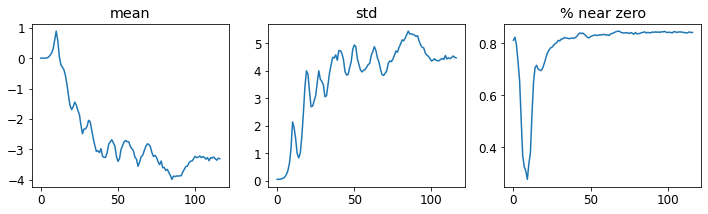

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
# Batch normalization 사용해야 하는 이유.

'''
Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, 
as the parameters of the previous layers change.
This slows down the training by requiring lower learning rates and careful parameter initialization…
We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

'''
# 각 layer마다 사용되는 채널수가 계속 바뀌니까, 이것이 training을 느리게 만들어버림.

# Batch normalzaiton 도입
'''
Making normalization a part of the model architecture and performing the normalization for each training mini-batch.
Batch Normalization allows us to use much higher learning rates and be less careful about initialization.
'''


# Batch normalization의 두 가지 파라미터
''' 
Batch normalization (often called batchnorm) works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. However, this can cause problems because the network might want some activations to be really high in order to make accurate predictions. So they also added two learnable parameters (meaning they will be updated in the SGD step), usually called gamma and beta. After normalizing the activations to get some new activation vector y, a batchnorm layer returns gamma*y + beta.
'''

# Batch Norm이 도움이 되는 이유
'''
An interesting observation about models containing batch normalizationlayers is that they tend to generalize better than models thatdon’t contain them.
 Although we haven’t as yetseen a rigorous analysis of what’s going on here, 
 most researchers believe that the reason is that batch normalization adds some extra randomness to the training process. 
 Each mini-batch willhave a somewhat different mean and standard deviation than other mini-batches. 
 Therefore, the activations will be normalized by different values each time. In order for the model to make accurate predictions,
 it will have to learn to become robust to these variations. Ingeneral, adding additional randomization to the training process oftenhelps.

'''
 


In [ ]:
# Batch normalziation 적용하기
def conv(ni, nf, ks = 3, act = True):
  layers = [nn.Conv2d(ni,nf,stride = 2, kernel_size= ks, padding= ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)



/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.267304,0.191313,0.940900,01:16
1,0.089305,0.082262,0.974100,01:15
2,0.052544,0.043429,0.986700,01:15
3,0.034164,0.028202,0.991600,01:15
4,0.017414,0.023798,0.991800,01:15


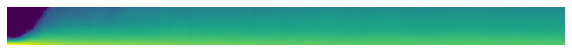

In [ ]:
learn = fit(5, lr = 0.1)

learn.activation_stats.color_dim(-4)
